In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Specify the path where you want to store the unzipped files in your Google Drive
output_folder = '/content/drive/MyDrive/srgan model main folder'

# Make sure the folder exists, create it if it doesn't
!mkdir -p "$output_folder"

# Unzip the file to the specified folder
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip -q DIV2K_train_HR.zip -d "$output_folder"



--2024-05-12 21:53:59--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-05-12 21:54:00--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  21.7MB/s    in 2m 57s  

2024-05-12 21:56:58 (19.0 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [7]:
import torch
import math
import torchvision
from torchvision import transforms
from os import listdir
import pandas as pd
import numpy as np

from torch.autograd import Variable
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from PIL import Image
from os.path import join
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid

import warnings
warnings.filterwarnings("ignore")

In [8]:
torch.autograd.set_detect_anomaly(True)


In [36]:
UPSCALE_FACTOR = 4
CROPSIZE = 88

#### Normalisation Parameters for pre-trained Pytorch models

In [37]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

#### Data Preparation and Transformations

In [38]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])



In [39]:
class TrainDatasetFromFolder(Dataset):
  def __init__(self, dataset_dir, crop_size, upscale_factor):
    super(TrainDatasetFromFolder, self).__init__()
    self.image_filenames = [join(dataset_dir,x) for x in listdir(dataset_dir) if is_image_file(x)]
    crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
    self.hr_transform = train_hr_transform(crop_size)
    self.lr_transform = train_lr_transform(crop_size, upscale_factor)


  def __getitem__(self, index):
    hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
    lr_image = self.lr_transform(hr_image)
    return lr_image, hr_image


  def __len__(self):
    return len(self.image_filenames)

#### Training of the Model

In [40]:
train_set = TrainDatasetFromFolder("/content/drive/MyDrive/srgan model main folder/DIV2K_train_HR", crop_size=CROPSIZE, upscale_factor= UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

In [41]:
from torch import nn, optim

In [42]:
# Implementing the Model by class format

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size =3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size =3, padding =1)
    self.bn2 = nn.BatchNorm2d(channels)

  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual



In [43]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size =3, padding =1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [44]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

In [45]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

In [46]:
from torchvision.models.vgg import vgg19

In [47]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [48]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg19(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss

In [49]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cpu')

In [50]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [57]:
generator_criterion = GeneratorLoss()

In [52]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [53]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0001)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)

In [54]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score":[],
    "g_score":[]
}

In [55]:
## Now for training code
from tqdm import tqdm
import os

In [56]:
N_EPOCHS = 2

In [58]:
for epoch in range(1, N_EPOCHS +1):
  train_bar =tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0,"d_score":0,"g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## Update Discriminator ##
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## Now update Generator
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    ## Updating the progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()



[1/2] Loss_D: 0.8165 Loss_G: 0.0521 D(x): 0.5601 D(G(z)): 0.5601: 100%|██████████| 13/13 [00:48<00:00,  3.70s/it]
[2/2] Loss_D: 0.6592 Loss_G: 0.0210 D(x): 0.6426 D(G(z)): 0.6426: 100%|██████████| 13/13 [00:51<00:00,  3.93s/it]


In [59]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Specify the path to the folder where you want to save the models in your Google Drive
model_folder = '/content/drive/MyDrive/srgan model main folder'
# os.makedirs(model_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Specify the filenames for your trained models
generator_filename = 'netG.pth'
discriminator_filename = 'netD.pth'

# Combine the folder path and filenames
generator_save_path = os.path.join(model_folder, generator_filename)
discriminator_save_path = os.path.join(model_folder, discriminator_filename)

# Save the generator model
torch.save(netG.state_dict(), generator_save_path)

# Save the discriminator model
torch.save(netD.state_dict(), discriminator_save_path)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Testing of the Model saved

In [75]:
from torchvision.transforms import Normalize
def preprocess_image(image_path):
    """
    Preprocesses an image by resizing and normalizing it.

    Args:
        image_path (str): Path to the input image file.
        target_size (tuple): Desired size of the output image (height, width). Default is (256, 256).

    Returns:
        torch.Tensor: Preprocessed image tensor.
    """
    # Open the image using PIL
    image = Image.open(image_path).convert('RGB')

    # Resize the image to the target size
    transform = Compose([
        Resize(400),
        ToTensor(),  # Convert image to tensor

    ])

    # Apply transformations
    preprocessed_image = transform(image)

    # Normalize pixel values
    normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocessed_image = normalize(preprocessed_image)

    return preprocessed_image

Uploading my image

In [80]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving home.jpg to home.jpg


In [89]:
from PIL import Image
import torch

# Load the saved models
generator_path = '/content/drive/MyDrive/srgan model main folder/netG.pth'
discriminator_path = '/content/drive/MyDrive/srgan model main folder/netD.pth'

# Assuming Generator and Discriminator classes are defined as Generator and Discriminator

# Create instances of Generator and Discriminator
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

# Load the saved state dictionaries
netG.load_state_dict(torch.load(generator_path))
netD.load_state_dict(torch.load(discriminator_path))

# Set the models to evaluation mode
netG.eval()
netD.eval()

# Load the test image
test_image_path = '/content/drive/MyDrive/srgan model main folder/DIV2K_train_HR/0003.png'
test_image = Image.open(test_image_path).convert('RGB')

# Preprocess the test image if necessary

preprocessed_image = preprocess_image(test_image_path)

# Convert the image to a tensor and add batch dimension
input_tensor = torch.unsqueeze(preprocessed_image, 0)

# Pass the test image through the generator to get the generated image
with torch.no_grad():
    generated_image = netG(input_tensor)

# Pass both the original and generated images through the discriminator to get their scores
with torch.no_grad():
    original_score = netD(input_tensor)
    generated_score = netD(generated_image)

# Calculate accuracy
accuracy = (original_score.item() + 1 - generated_score.item()) / 2 * 100

print("Accuracy:", accuracy)


Accuracy: 75.8668377995491


#### Visualization of the images

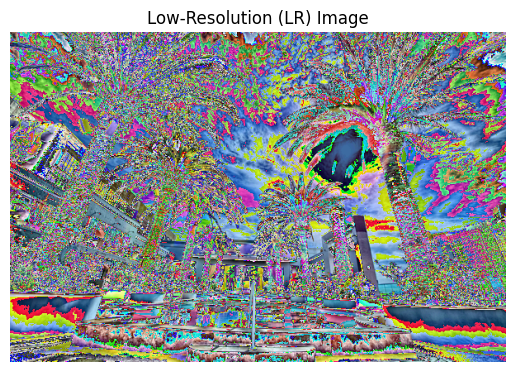

In [90]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Load the test image
test_image = Image.open(test_image_path).convert('RGB')

# Preprocess the test image
lr_image = preprocess_image(test_image_path)

# Convert the LR image tensor to a PIL Image
lr_image_pil = TF.to_pil_image(lr_image)

# Display the LR image
plt.imshow(lr_image_pil)
plt.title('Low-Resolution (LR) Image')
plt.axis('off')
plt.show()

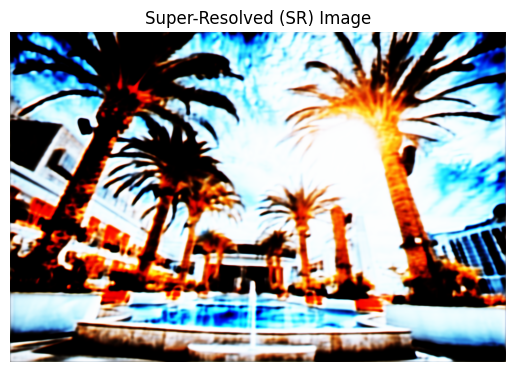

In [96]:
# Assuming generated_image is a batch of super-resolved images
# Select the first image from the batch
sr_image_tensor = generated_image[0]

# Convert the super-resolved image tensor to a PIL Image
sr_image_pil = TF.to_pil_image(sr_image_tensor)

# Display the SR image
plt.imshow(sr_image_pil)
plt.title('Super-Resolved (SR) Image')
plt.axis('off')
plt.show()


### Testing with my file in jpg format

In [97]:
from PIL import Image
import torch

# Load the saved models
generator_path = '/content/drive/MyDrive/srgan model main folder/netG.pth'
discriminator_path = '/content/drive/MyDrive/srgan model main folder/netD.pth'

# Assuming Generator and Discriminator classes are defined as Generator and Discriminator

# Create instances of Generator and Discriminator
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

# Load the saved state dictionaries
netG.load_state_dict(torch.load(generator_path))
netD.load_state_dict(torch.load(discriminator_path))

# Set the models to evaluation mode
netG.eval()
netD.eval()

# Load the test image
test_image_path = '/content/home.jpg'
test_image = Image.open(test_image_path).convert('RGB')

# Preprocess the test image if necessary

preprocessed_image = preprocess_image(test_image_path)

# Convert the image to a tensor and add batch dimension
input_tensor = torch.unsqueeze(preprocessed_image, 0)

# Pass the test image through the generator to get the generated image
with torch.no_grad():
    generated_image = netG(input_tensor)

# Pass both the original and generated images through the discriminator to get their scores
with torch.no_grad():
    original_score = netD(input_tensor)
    generated_score = netD(generated_image)

# Calculate accuracy
accuracy = (original_score.item() + 1 - generated_score.item()) / 2 * 100

print("Accuracy:", accuracy)


Accuracy: 85.32283902168274


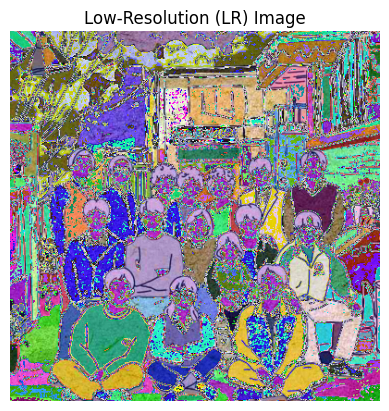

In [98]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Load the test image
test_image = Image.open(test_image_path).convert('RGB')

# Preprocess the test image
lr_image = preprocess_image(test_image_path)

# Convert the LR image tensor to a PIL Image
lr_image_pil = TF.to_pil_image(lr_image)

# Display the LR image
plt.imshow(lr_image_pil)
plt.title('Low-Resolution (LR) Image')
plt.axis('off')
plt.show()

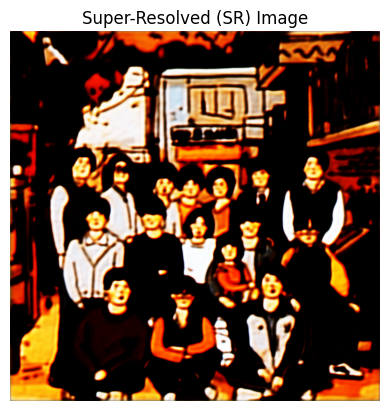

In [99]:
# Assuming generated_image is a batch of super-resolved images
# Select the first image from the batch
sr_image_tensor = generated_image[0]

# Convert the super-resolved image tensor to a PIL Image
sr_image_pil = TF.to_pil_image(sr_image_tensor)

# Display the SR image
plt.imshow(sr_image_pil)
plt.title('Super-Resolved (SR) Image')
plt.axis('off')
plt.show()

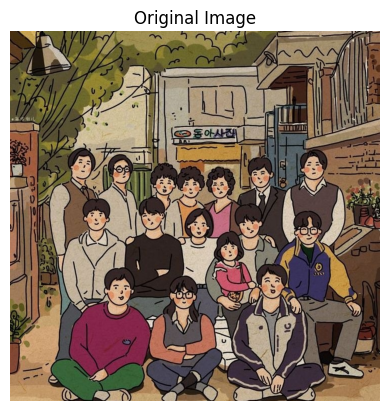

In [101]:
# Load the original HR image
original_image = Image.open(test_image_path).convert('RGB')
# Display the original image
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.show()